<a href="https://colab.research.google.com/github/SKSwarnkar/DiabeticRetinopathy_Using_CNN/blob/master/3_Combined_Models_for_diabeticretinopathy_Satish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Diabetic RetinopathyDetection**

This Notebook aims to provide a prediction kernel using Transfer  - Fine Tuned VGG-16 architecture.


In [0]:
#! pip install jsonpickle imutils pillow scikit-image h5py seaborn tqdm jupyterlab jupyter_http_over_ws
#! pip install scikit-learn pandas graphviz keras tensorflow-gpu==1.15 

In [0]:
import time
def print_time():
  current_time=time.localtime()
  time_stamp=time.strftime('%Y.%m.%d-%H:%M:%S-%Z', current_time)
  #print("Now1:", time_stamp)
  return(time_stamp)

#print_time()

In [0]:
import sys
import datetime
redirect_stdout=True
redirect_to_colab=True

#sys.stdout = sys.__stdout__

current_time=print_time()
LogFile="log"
logfiles=[str(current_time),LogFile,'txt']
logfilename='.'.join(logfiles)

orig_stdout = sys.stdout

if (redirect_stdout):
  #datetime_object = datetime.datetime.now()
  #logfiles=[LogFile,str(datetime_object),'txt']
  if (redirect_to_colab != True):
    logfilename=MyDriveDir+'/'+logfilename
  file_id = open(logfilename, 'w')
  sys.stdout = file_id
else:
    print("Timestamp:", current_time)
    print("\n=============================================================================")


In [0]:
import numpy as np
import os
import time
import tensorflow as tf 
import logging
from tensorflow.python.client import device_lib

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"


#print(tf.__version__)
#print(device_lib.list_local_devices())
#print("\n=============================================================================")

**Set Google drive variable**

---



In [0]:
#all variable are defined here

mount_directory='/content/gdrive'
csv_file_name="/content/gdrive/My Drive/Colab Notebooks/Retinopathy_Files/trainLabels.csv"
img_dir_name='/content/gdrive/My Drive/Colab Notebooks/Retinopathy_Files/train_tiny'
MyDriveDir='/content/gdrive/My Drive/Colab Notebooks/Retinopathy_Files'

**Mount and load the dataset from google drive**

---



In [0]:
from google.colab import drive
drive.mount(mount_directory)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········


In [0]:
#!ls -l "/content/gdrive/My Drive/Colab Notebooks/Retinopathy_Files"
#!du -h '/content/gdrive/My Drive/Colab Notebooks/Retinopathy_Files/train_tiny'
#print("\n=============================================================================")

**Define all variables here**

---



In [0]:
# input image dimensions
img_rows, img_cols = 224, 224
input_shape=(img_rows, img_cols, 3)
train_labels_head=10
plot_img_size=16

#Data Parameters
#keep data_set_size multiple of 100s
data_set_size=1600
#equalize_samples=True
use_non_zero_data_only=False
binary_classification=True
nb_classes=2
percent_test_data=0.5

#Model parameters
#make sure batchsize/nb_epoch is not a fraction
batchsize=32
nb_epoch = 128
layer_depth=32
dense_layer_size=512
learning_rate=0.00001
activation_func='relu'

#Model to run
run_model_with_stride_lenghts=True
run_VGG_model=True
run_ResNet_model=True

In [0]:
def print_all_variables():
  #print all variables
  print("Project Report\n")
  print("Parameters:\n")
  print("* img_rows, img_cols", img_rows, img_cols)
  print("* input_shape", input_shape)
  print("* train_labels_head", train_labels_head)
  print("* plot_img_size", plot_img_size)
  print()

  #Data Parameters
  print("* data_set_size", data_set_size)
  print("* use_non_zero_data_only",use_non_zero_data_only)
  print("* binary_classification-True", binary_classification)
  print("* nb_classes", nb_classes)
  print("* percent_test_data", percent_test_data)
  print()

  #Model parameters
  print("* batchsize", batchsize)
  print("* nb_epoch", nb_epoch)
  print("* layer_depth", layer_depth)
  print("* dense_layer_size", dense_layer_size)
  print("* learning_rate", learning_rate)
  print("* activation_func", activation_func)
  print()
  
  #Model to run
  print("* run_model_with_stride_lenghts", run_model_with_stride_lenghts)
  print("* run_VGG_model", run_VGG_model)
  print("* run_ResNet_model", run_VGG_model)
  print("\n=============================================================================")

In [0]:
print_all_variables()

In [0]:
#All Necessary Imports
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Dense, Dropout, Flatten, Activation # importing different types of layers that you can use with your model
from keras.layers import Conv2D, MaxPooling2D, MaxPooling1D # same as above
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
#from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import regularizers

import matplotlib.pyplot as plt
import matplotlib


Using TensorFlow backend.


**Loading the dataset**

---



In [0]:
import pandas as pd
trainLabels = pd.read_csv(csv_file_name)

**Finding class distribution**

In [0]:
#import seaborn as sns
#sns.countplot(x="level", data= trainLabels)


In [0]:
#import os
listing = os.listdir(img_dir_name) 
np.size(listing)

1600

**Data Augmentation (open and resize and load all the files)**

---


In [0]:
from tqdm import tqdm
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

immatrix = []
imlabel = []
imname = []
actual_data_level_count=[0,0,0,0,0]
data_level_count=[0,0,0,0,0]
file_count=0
non_zero_file_count =0
disease_count = 0
s_name = []
sl_val = []

for file in listing:
  if (file_count < data_set_size):
    try:  
        base = os.path.basename(img_dir_name + "/" + file)
        fileName = os.path.splitext(base)[0]
        # Get the Severity level of Diabetic Retinopathy
        s_level = trainLabels.loc[trainLabels.image==fileName, 'level'].values[0]
        actual_data_level_count[s_level] += 1
        if (binary_classification):
          if(s_level > 0):
            nb_classes=2
            s_level = 1;
        file_count += 1
        if (use_non_zero_data_only):
          non_zero_file_count +=1;
          nb_classes=4
          if (s_level > 0):
            s_level = s_level -1
            data_level_count[s_level] += 1
            s_name.append(non_zero_file_count)
            #sl_val.append(s_level)
            # The following 6 lines can be moved inside if (s_level) code to get only Level 1 and above data
            im = Image.open(img_dir_name + "/" + file)   
            img = im.resize((img_rows,img_cols))
            rgb = img.convert('RGB')
            imlabel.append(s_level)
            imname.append(fileName)
            immatrix.append(np.array(rgb).flatten())
            # The above three lines will store the label and file into an array
            disease_count += 1
        else:
          data_level_count[s_level] += 1
          s_name.append(file_count)
          # The following 6 lines can be inside if (s_level) code to get only Level 1 and above data
          im = Image.open(img_dir_name + "/" + file)   
          img = im.resize((img_rows,img_cols))
          rgb = img.convert('RGB')
          imlabel.append(s_level)
          imname.append(fileName)
          immatrix.append(np.array(rgb).flatten())
          if (s_level > 0):
            disease_count += 1
          # The above three lines will store the label and file into an array
        # print(fileName, s_level)
    except Exception as e:
        print("Unable to process image: ", base, ". Error: ", e)

print("Dataset:\n")
print("* Loaded Data & Label :", file_count, "out of", len(listing))
print("* Count of each Label:", actual_data_level_count)
print("* Normal images:", (file_count - disease_count),". Files with symptoms:", disease_count)
print("\n=============================================================================")

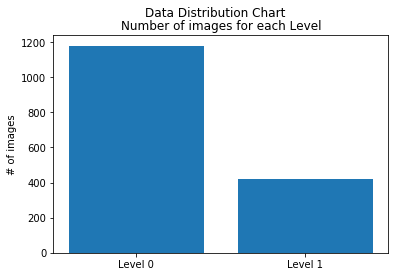

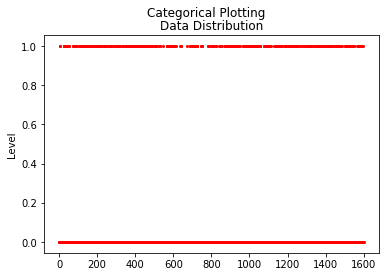

In [0]:
if (nb_classes == 2):
  names = ['Level 0', 'Level 1']
  values = [data_level_count[0], data_level_count[1]]
elif (nb_classes == 4):
  names = ['Level 0', 'Level 1', 'Level 2', 'Level 3']
  values = [data_level_count[0], data_level_count[1], data_level_count[2], data_level_count[3]]
else:
  names = ['Level 0', 'Level 1', 'Level 2', 'Level 3', 'Level 4']
  values = [data_level_count[0], data_level_count[1], data_level_count[2],data_level_count[3],data_level_count[4]]

                    
#bar_chart=plt.figure(figsize=(18, 6))

print("Data Distribution Chart\n")

#plt.subplot(121)
plt.suptitle('Data Distribution Chart\n')
plt.title('Number of images for each Level')
plt.ylabel('# of images')
plt.bar(names,values)

LogFile="bar.chart"
logfiles=[str(current_time),LogFile,'jpg']
logfilename='.'.join(logfiles)
                     
plt.savefig(logfilename)
plt.show()

#plt.subplot(122)
plt.suptitle('Categorical Plotting')
plt.title('Data Distribution')
plt.ylabel('Level')
plt.scatter(s_name, imlabel, c='red', s=4)

LogFile="scatter.plot"
logfiles=[str(current_time),LogFile,'jpg']
logfilename='.'.join(logfiles)

plt.savefig(logfilename)
plt.show()


In [0]:
from sklearn.utils import shuffle

#converting images & labels to numpy arrays
immatrix = np.asarray(immatrix)
imlabel = np.asarray(imlabel)

data,Label,fName = shuffle(immatrix,imlabel,imname, random_state=2)
train_data = [data,Label,fName]
#type(train_data)

**Plot few images in rows and columns**

---



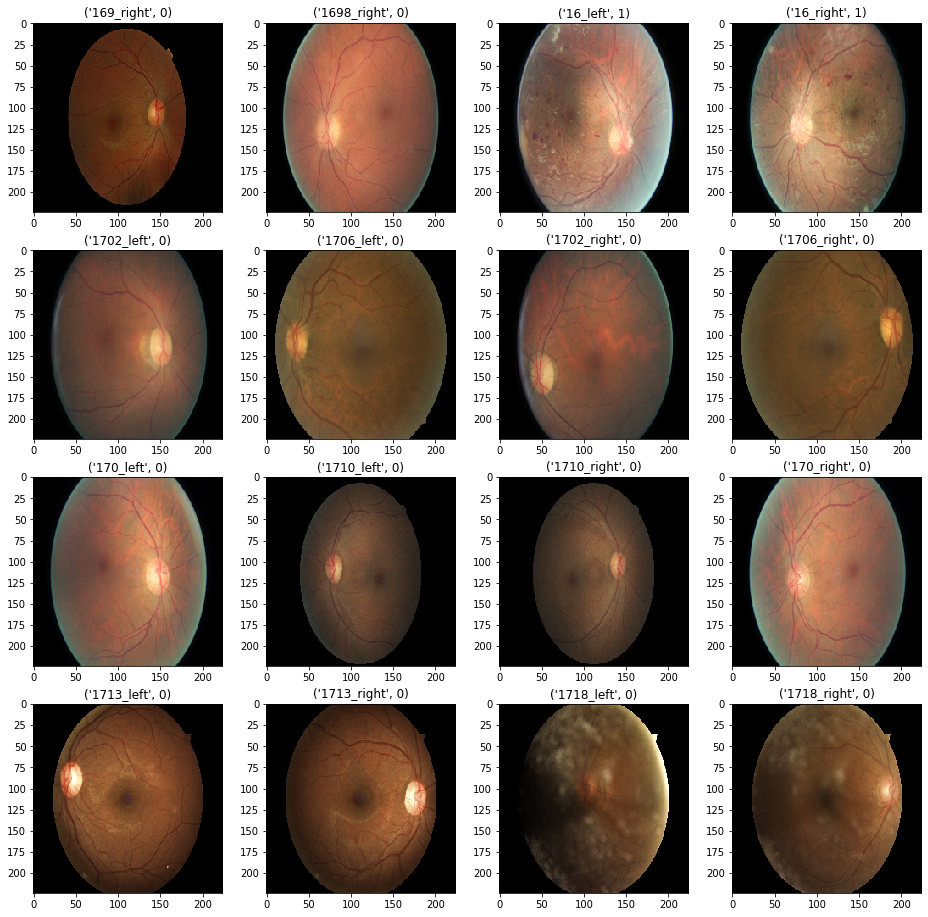

In [0]:
fig=plt.figure(figsize=(plot_img_size, plot_img_size))
if (disease_count > 16):
  rows = columns = 4
else:
  columns = rows = int(disease_count**0.5)
print("Sample Images:\n")
for i in range(columns*rows):
    img=immatrix[i].reshape(img_rows,img_cols,3)
    mytitle=fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    title_var=imname[i], imlabel[i]
    mytitle.set_title(title_var)

LogFile="images"
logfiles=[str(current_time),LogFile,'jpg']
logfilename='.'.join(logfiles)
    
plt.savefig(logfilename)
plt.show()
    

**Sample Label Data from CSV File**

---



In [0]:
print("Sample Label Data (CSV file):")
trainLabels.head(train_labels_head)

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
5,15_right,2
6,16_left,4
7,16_right,4
8,17_left,0
9,17_right,1


**Splitting Dataset to training and test samples**

---



In [0]:
(img_data, lbl_data, f_data) = (train_data[0],train_data[1],train_data[2])
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

# STEP 1: split img_data, lbl_data, f into training and testing sets
img_train, img_test, lbl_train, lbl_test, file_train, file_test = train_test_split(img_data, lbl_data, f_data, test_size=percent_test_data, random_state=4)

img_train = img_train.reshape(img_train.shape[0], img_cols, img_rows, 3)
img_test = img_test.reshape(img_test.shape[0], img_cols, img_rows, 3)

print("Training Data:\n")
print("* Training Images:", img_train.shape, "Training Label:", lbl_train.shape)

print("* Test image:", img_test.shape, "Test Label:", lbl_test.shape)


In [0]:
# STEP 2: Normalize the values from 0-1
img_train = img_train.astype('float32')
img_test = img_test.astype('float32')

img_train /= 255
img_test /= 255

#print('img_train shape:', img_train.shape)
#print(img_train.shape[0], 'train samples, ', end=" ")
#print(img_test.shape[0], 'test samples')

In [0]:
from keras.utils import np_utils

# convert class vectors to binary class matrices
Lbl_bin_train = np_utils.to_categorical(lbl_train, nb_classes)
Lbl_bin_test = np_utils.to_categorical(lbl_test, nb_classes)

**Performing Image augmentation**

In [0]:
#VGG
from keras.preprocessing.image import ImageDataGenerator

# create generators  - training data will be augmented images
validationdatagenerator = ImageDataGenerator()
traindatagenerator = ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.1,rotation_range=15,zoom_range=0.1 )

#batchsize=8
train_generator=traindatagenerator.flow(img_train, Lbl_bin_train, batch_size=batchsize) 
validation_generator=validationdatagenerator.flow(img_test, Lbl_bin_test,batch_size=batchsize)

**Create_model function to create model with specified stride_values**

---



In [0]:
print("Create Models:\n")

In [0]:
#This function creates a model with stride_value
#if the stride_val is more than 1 it adds additional 3 layers

def create_model(stride_val):
    
  # Create the model
  model = models.Sequential()
  
  # Add the Convolutional model
  model.add(layers.Conv2D(layer_depth, kernel_size=(3, 3), strides=(stride_val,stride_val), activation=activation_func, input_shape=input_shape))
  model.add(layers.Conv2D(layer_depth, kernel_size=(3, 3), strides=(stride_val,stride_val), activation=activation_func))
  model.add(layers.MaxPooling2D(pool_size=2))

  #if (stride_val >= 2):

  model.add(layers.Conv2D(layer_depth, kernel_size=(3, 3), strides=(stride_val,stride_val), activation=activation_func))
  #model.add(layers.Conv2D(layer_depth, kernel_size=(3, 3), strides=(stride_val,stride_val), activation=activation_func))
  model.add(layers.MaxPooling2D(pool_size=2))
  #
  # Add the fully connected layers
  model.add(layers.Flatten())
  model.add(layers.Dense(layer_depth, activation=activation_func))
  model.add(layers.Dropout(0.5))
  model.add(Dense(nb_classes, activation='softmax', input_dim=64,
                kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))
  #model.add(layers.Dense(nb_classes, activation='softmax', name ='output'))
 
  #Print Model summary
  model.summary()

  return model

In [0]:
#Add all models to an array
all_models = []

In [0]:
if (run_model_with_stride_lenghts):
  for i in [1,2,3]:
    print("Stride Length =", i)
    test_model=create_model(i)
    # Show a summary of the model. Check the number of trainable parameters
    all_models.append(test_model)

**Model Selection**

We load the base model, which is a VGG-16 model pretrained on imagenet weights.
We then move on to freeze all the layers except the last three.

Before we go about pre processing data and training our loaded model, we fix the following
* Batch Size of the data required for training
* nb_classes -> indicates the number of output classes
* nb_epoch -> induicates the number of iterations during training 

**Fine Tune : Architecture 1 with 3 Conv Layer**

We move on to add customised layers for a new architecture
The following layers were added :
* Conv2D Relu
  - keras.layers.Conv2D(filters, kernel_size, strides=(1, 1),
  padding='valid', data_format=None, dilation_rate=(1, 1),
  activation=None, use_bias=True, kernel_initializer='glorot_uniform',
  bias_initializer='zeros', kernel_regularizer=None,
  bias_regularizer=None, activity_regularizer=None,
  kernel_constraint=None, bias_constraint=None)

* Dropout
* Dense Softmax

In [0]:
def create_VGG16_model(dense_layer_size):
  # Create the model
  model = models.Sequential()
  
  # Add the vgg convolutional base model
  base_model = VGG16(weights='imagenet', include_top=True, input_shape=input_shape)

  for layer in base_model.layers[:-3]:
    layer.trainable = False

  model.add(base_model)
  # Add new layers
  model.add(layers.Dense(dense_layer_size, activation=activation_func))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(nb_classes, activation='softmax', name ='output'))
  
  #Print Model summary
  model.summary()
  
  return model

In [0]:
#Add VGG model too
#loading base model
if (run_VGG_model):
  vgg_model=create_VGG16_model(dense_layer_size)
  all_models.append(vgg_model)

In [0]:
from keras.applications.resnet50 import ResNet50
def create_ResNet_model(dense_layer_size):
  # Create the model
  model = models.Sequential()
  #loading base model
  base_model = ResNet50(weights='imagenet', include_top=True, input_shape=input_shape)

  for layer in base_model.layers[:-6]:
    layer.trainable = False

  model.add(base_model)
  # Add new layers
  model.add(layers.Dense(dense_layer_size, activation=activation_func))
  model.add(layers.Dense(dense_layer_size*2, activation=activation_func))
  model.add(layers.Dense(dense_layer_size*2, activation=activation_func))
  #model.add(layers.Dropout(0.5))
  model.add(layers.Dense(nb_classes, activation='softmax', name ='output'))
  
  #Print Model summary
  model.summary()

  return model



In [0]:
#Add ResNet model too
#loading base model
if (run_ResNet_model):
  resnet_model=create_ResNet_model(dense_layer_size)
  all_models.append(resnet_model)

**Function to plot the charts**

In [0]:
def myplot(history,index):
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model '+str(index+1)+' Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper left')
  
  LogFile='model'+str(index+1)+'_accuracy'
  logfiles=[str(current_time),LogFile,'jpg']
  logfilename='.'.join(logfiles)

  plt.savefig(logfilename)
  plt.show()

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model '+str(index+1)+' Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper left')

  LogFile='model'+str(index+1)+'_loss'
  logfiles=[str(current_time),LogFile,'jpg']
  logfilename='.'.join(logfiles)

  plt.savefig(logfilename)
  plt.show()


**Compile and Train the models**

---



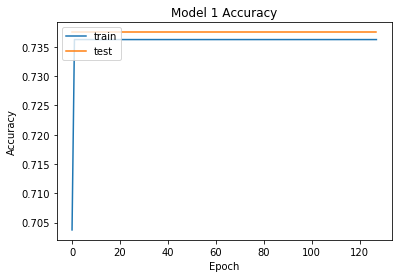

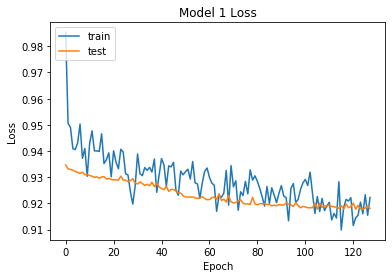

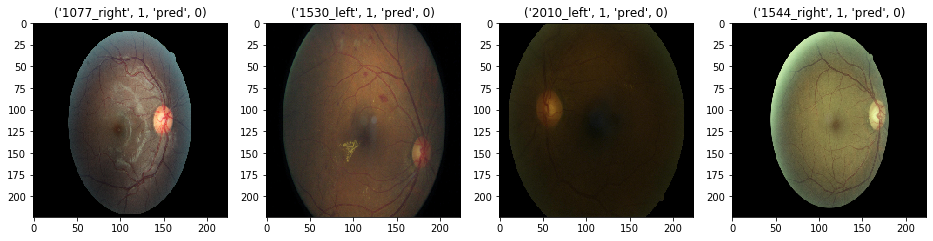

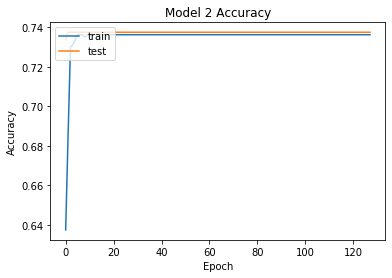

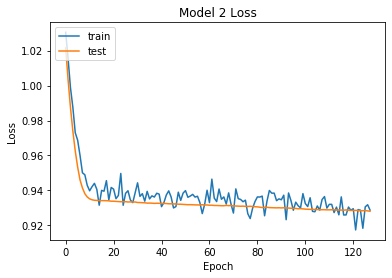

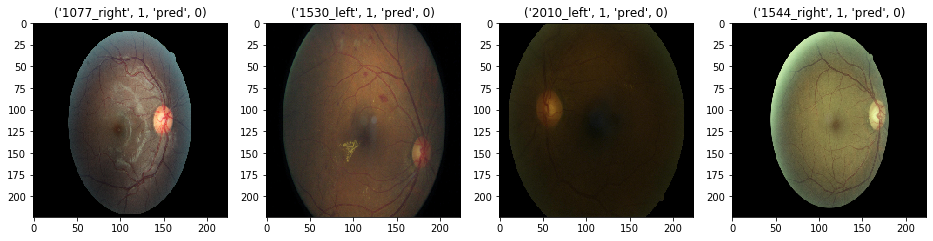

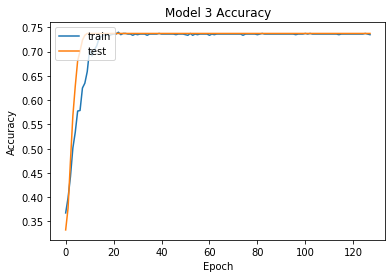

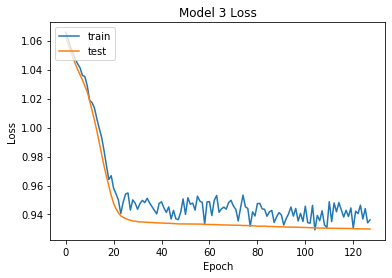

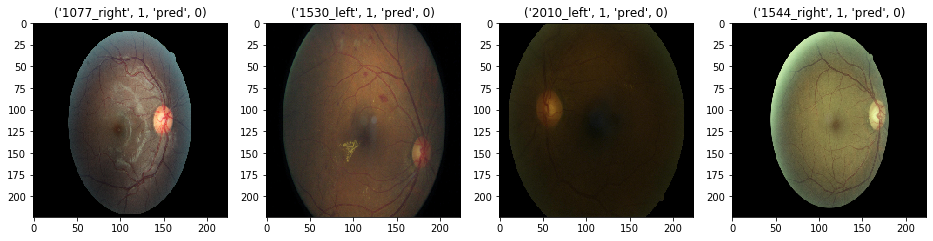

In [0]:
#from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.models import load_model


#print("=============================================================================")
print("Train Convolutional Neural Network Models")
print("=============================================================================")
#print(Timestamp: print_time())

for index, model_i in enumerate(all_models):
  print("\nModel:", index+1)
  print("\n=============================================================================")
  print("Timestamp:", print_time())

  optim = Adam(lr=learning_rate)

  model_i.compile(loss='categorical_crossentropy',
                optimizer=optim,
                metrics=['acc'])
 
  print("\nCompile done, Model:", index+1)
  history= model_i.fit_generator(train_generator, steps_per_epoch=int(len(img_train)/batchsize), 
                    epochs=nb_epoch, verbose=0, validation_data=validation_generator, 
                    validation_steps=int(len(img_test)/batchsize))
  #history = model_i.fit(img_train, Lbl_bin_train, batch_size=batchsize, epochs=nb_epoch, verbose=0, validation_data=(img_test, Lbl_bin_test), shuffle=True)

  print("\nTraining complete, Model:", index+1)
  myplot(history,index)

  score = model_i.evaluate(img_test, Lbl_bin_test, verbose=0)
  print('\nEvaluate Complete. Model:', index+1)
  print('* Test loss:', score[0],'Test accuracy:', score[1])
 
  #Log file for all predictions
  #LogFile="predict"
  #logfiles=[str(current_time),LogFile,'txt']
  #logfilename='.'.join(logfiles)
  #predict_fid= open(logfilename, 'w')
  predict_results=2

  print("\n\nPredictions for Model:", index+1)
  print("\n=============================================================================")
  y_pred = []
  non_zero_list_array=[]
  draw_img=True
  correct_predictions=0
  wrong_prediction=0
  predict_results=0

  Ground_truth_names = ["None","Level 1","Level 2","Level 3","Level 4"]
  for i in range (img_test.shape[0]):
      test_image = img_test[i]
      imagematrix =  np.asarray(test_image)
      imagepredict = np.expand_dims(imagematrix, axis=0)
      
      y_pred1 = model_i.predict(imagepredict,verbose=0)  
      y_pred2=np.max(y_pred1)
      y_pred3=np.argmax(y_pred2)
      #
      y_pred.append(y_pred2)
      pred_value = [round((x * 100),0) for x in y_pred1[y_pred3]]
      y_pred_index=np.argmax(y_pred1[y_pred3])

      label_value=lbl_test[i]
      if (label_value == y_pred_index):
        correct_predictions += 1
        #print("i,range,y_ind,lable_val",i,img_test.shape[0],y_pred_index, label_value)
      if (label_value != y_pred_index):
        wrong_prediction += 1

      #Print name of image and label
      if (predict_results < 4 and label_value > 0):
        non_zero_list_array.append(i)
        print(" >Image:", file_test[i], end=", ")
        print("Label:", label_value, end=", ")
        # Predicted value
        print("Predicted:", str(round((100*y_pred2),0))+'%, ', Ground_truth_names[y_pred_index], ",", end=" ")
        print("[", end="")
        print(*pred_value, sep ="%, ", end="%")
        print("]")
        predict_results += 1
        if (label_value):
          draw_img=True
  
  y_pred_array = np.asarray(y_pred)
  print("\n")
  print("* Mean confidence value of prediction: ",str(round(100*(np.mean(y_pred_array)),2))+'%')
  print("* Correct Predictions", str(round(100*(correct_predictions/img_test.shape[0]),2))+'%', ", Correct:", correct_predictions, ", Incorrect:", wrong_prediction, ", Total:", img_test.shape[0] )
  
  print("\n")


  if (draw_img and len(non_zero_list_array) >=4):
    fig=plt.figure(figsize=(plot_img_size, plot_img_size/4))
    columns = 4
    rows= 1
    for j in range(columns*rows):
      #
      LogFile='model'+str(index+1)+'_predictions'
      logfiles=[str(current_time),LogFile,'jpg']
      logfilename='.'.join(logfiles)
      #
      plt.savefig(logfilename)
      #
      mytitle=fig.add_subplot(rows, columns, j+1)
      img_id=non_zero_list_array[j]
      plt.imshow(img_test[img_id])
      title_var=file_test[img_id], lbl_test[img_id],"pred",y_pred_index
      mytitle.set_title(title_var)
  plt.show()
  print("\nPredications complete, Model:", index+1)

print("\n============================== END of PROGRAM ===============================")
print("Timestamp:", print_time())
if (redirect_stdout):
  file_id.close()
  sys.out = orig_stdout



  
